In [60]:
import math
# ------------------------------
import numpy as np
import numpy.random as rand
# ------------------------------
import scipy.stats as stats
from scipy.interpolate import Rbf
# ------------------------------
from sklearn.datasets import make_blobs
# ------------------------------
from numba import cuda, vectorize
# ------------------------------
import pycuda.gpuarray as gpuarray
import pycuda.autoinit
import numpy as np
import skcuda.linalg as linalg
# ------------------------------
import matplotlib.pyplot as plt

In [61]:
head = lambda x: x[0:6]
tail = lambda x: x[-6:]
# ------------------------------
point_dtype = np.dtype({
    'names':   ['x', 'y'],
    'formats': [np.float32, np.float32]})

# Device function

In [62]:
@cuda.jit(device = True)
def dist2_kernel(point1, point2):
    return math.pow(point1["x"] - point2["x"], 2) + math.pow(point1["y"] - point2["y"], 2)

In [63]:
@cuda.jit(device = True)
def dist2weight_kernel(distance_square):
    #if (kernel == "standard normal"):
    return math.exp(-1 * distance_square)
    

# Main Kernel function: get_weights

In [64]:
# signature: point_dtype[:], point_dtype[:], float[:, :]
@cuda.jit
def get_weights(grids, points, weights):  
    idx_grid, idx_point = cuda.grid(2)
    if (idx_grid < weights.shape[0]) & (idx_point < weights.shape[1]):
        # intialization
        grid  = grids[idx_grid]
        point = points[idx_point]
        
        # calculate distance and then convert to weights
        dist2 = dist2_kernel(grid, point)
        #x = np.array([grid.x - point.x, grid.y - point.y])
        #x_gpu = gpuarray.to_gpu(x)
        #dist2 = linalg.norm(x_gpu)
        
        weights[idx_grid, idx_point] = dist2weight_kernel(dist2)

# Helper function: convert a numpy 2d array to an array of points

In [65]:
def set_points(dat_pts):
    """Convert data frame of coordinates to an array of points
    
    >>> tmp = np.arange(10).reshape(-1, 2)
    >>> set_points(tmp)
    ... array([(0., 1.), (2., 3.), (4., 5.), (6., 7.), (8., 9.)],
      dtype=[('x', '<f8'), ('y', '<f8')])
    >>> set_points(tmp)[0]['x'], set_points(tmp)[0]['y']
    ... (0.0, 1.0)
    """
    num_pts = dat_pts.shape[0]
    points = np.empty((num_pts,), dtype = point_dtype)
    
    for idx in range(num_pts):
        p = points[idx]
        p['x'], p['y'] = dat_pts[idx][0], dat_pts[idx][1]
    
    return points

# Prepare data

## set parameters

In [66]:
N_POINTS = 1000
DIM_GRIDS = 50
mean = ([0.0, 0.0], [4.0, 4.0])
prop = (0.5, 0.5)

## distribution

suppose the underlying distribution is multivariate normal

In [67]:
distr1 = stats.multivariate_normal(mean = mean[0], cov = np.eye(2))
distr2 = stats.multivariate_normal(mean = mean[1], cov = np.eye(2))
distr_pdf  = lambda x: prop[0] * distr1.pdf(x) + prop[1] * distr2.pdf(x)

## data points

create data points with Gaussian kernel

In [68]:
dat_pts, y = make_blobs(
    n_samples = N_POINTS, 
    centers = mean, 
    cluster_std = 1.0,
    n_features = 2,
    random_state = 0)

coor_range = np.min(dat_pts[:, 0]), np.max(dat_pts[:, 1])

# get z value from multivariate binomial
value = np.apply_along_axis(distr_pdf, 1, dat_pts)

convert data points into an array of points

In [69]:
points = set_points(dat_pts)
print(points.shape)

(1000,)


visualize the data points

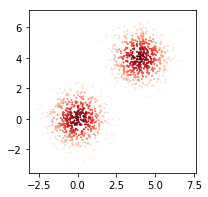

In [70]:
plt.figure(figsize=(3, 3))
plt.scatter(x = dat_pts[:, 0], y = dat_pts[:, 1], s = 1, c = value, cmap = "Reds")
plt.show()

## grids

create grids with linspace and meshgrid

In [71]:
# set up coordinates
x_c = np.linspace(coor_range[0], coor_range[1], DIM_GRIDS)
y_c = np.linspace(coor_range[0], coor_range[1], DIM_GRIDS)
x_c, y_c = np.meshgrid(x_c, y_c)

pos = np.empty(x_c.shape + (2,))
pos[:, :, 0] = x_c; pos[:, :, 1] = y_c

# get z value from multivariate binomial
z_c = distr_pdf(pos)

convert the meshgrid to numpy 2D matrix

In [72]:
dat_grids = np.array([x_c.ravel(), y_c.ravel()])
dat_grids = dat_grids.T
head(dat_grids)

array([[-2.65917224, -2.65917224],
       [-2.4693333 , -2.65917224],
       [-2.27949436, -2.65917224],
       [-2.08965542, -2.65917224],
       [-1.89981649, -2.65917224],
       [-1.70997755, -2.65917224]])

convert grids to an array of points

In [73]:
grids = set_points(dat_grids)
print(grids.shape)

(2500,)


visualize the grids

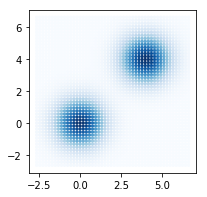

In [74]:
plt.figure(figsize=(3, 3))
plt.scatter(x = x_c, y = y_c, c = z_c, s = 5, cmap = "Blues", alpha = 1.0)
plt.show()

## Visualization of grids and points together

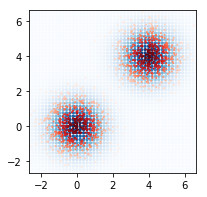

In [75]:
fig, axes = plt.subplots(1, 1, figsize=(3,3))

# grid points
axes.scatter(x = x_c, y = y_c, c = z_c, s = 5, cmap = "Blues", alpha = 1.0) #cmap='Blues')

# data points
axes.scatter(
    x = dat_pts[:, 0], 
    y = dat_pts[:, 1], 
    s = 1, c = value, 
    cmap = "Reds")

axes.set_xlim(coor_range)
axes.set_ylim(coor_range)
plt.show()

# Try my interpolation

In [76]:
print(grids.shape)
print(points.shape)

(2500,)
(1000,)


set up block and grid

In [77]:
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(grids.shape[0]  / threadsperblock[0])
blockspergrid_y = math.ceil(points.shape[0] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

initialize an empty weights and done the memory management

In [78]:
weights = np.empty(shape = (grids.shape[0], points.shape[0]), dtype = np.float32)
print(weights.shape)

grids_device    = cuda.to_device(grids)
points_device   = cuda.to_device(points)
weights_device  = cuda.device_array(shape=(weights.shape), dtype=np.float32)

(2500, 1000)


In [83]:
get_weights[blockspergrid, threadsperblock](grids, points, weights)
z_test = np.matmul(weights, value.reshape(N_POINTS, -1))
z_test = z_test.reshape(DIM_GRIDS, DIM_GRIDS)
print(z_test.shape)

(50, 50)


try using skcuda.linalg.mdot for matrix multiplication

In [82]:
# Examples
#A_gpu = gpuarray.to_gpu(A)
#B_gpu = gpuarray.to_gpu(B)
#AB_gpu = linalg.mdot(A_gpu, B_gpu)
#np.allclose(np.matmul(A, B), AB_gpu.get())

# make sure to convert the types to np.float32
weights = weights.astype(np.float32)
value = value.astype(np.float32).reshape(N_POINTS, -1)

# Try skcuda
linalg.init()
weights_gpu = gpuarray.to_gpu(weights)
value_gpu   = gpuarray.to_gpu(value)
z_test_gpu = linalg.mdot(weights_gpu, value_gpu)

np.allclose(
    z_test, 
    z_test_gpu.get().reshape(DIM_GRIDS, DIM_GRIDS))

True

benchmark: test whether skcuda save us some time

In [23]:
print("Matrix multiplication in Numpy")
%timeit np.matmul(weights, value)

Matrix multiplication in Numpy
146 µs ± 421 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
print("Matrix multiplication in skcuda")

Matrix multiplication in skcuda


In [25]:
%%timeit 
linalg.init()
weights_gpu = gpuarray.to_gpu(weights)
value_gpu   = gpuarray.to_gpu(value)
z_test_gpu = linalg.mdot(weights_gpu, value_gpu)

2.5 ms ± 38 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


it seems that for this small matrix, there is not much improvement

# Try Interpolation by Rdf

In [26]:
#rbfi = Rbf(dat_pts[:, 0], dat_pts[:, 1], value, function='multiquadric', smooth=1)
rbfi = Rbf(dat_pts[:, 0], dat_pts[:, 1], value, function='gaussian')
z_rbf = rbfi(x_c, y_c)
z_rbf.shape

(50, 50)

# Compare

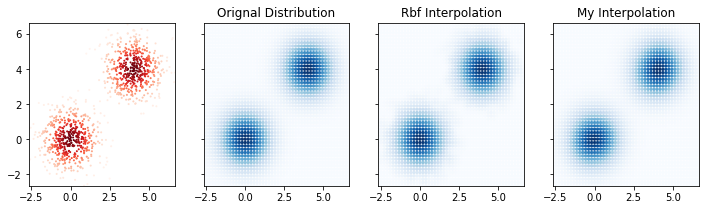

In [29]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex = True, sharey = True)

# sample points
axes[0].scatter(x = dat_pts[:, 0], y = dat_pts[:, 1], s = 1, c = value.reshape(-1,) , cmap = "Reds")

# bivariate normal
axes[1].scatter(x = x_c, y = y_c, c = z_c,    s = 5, cmap = "Blues", alpha = 1.0)
axes[1].set_title("Orignal Distribution")

# interpolation by Rbf
axes[2].scatter(x = x_c, y = y_c, c = z_rbf,  s = 5, cmap = "Blues", alpha = 1.0)
axes[2].set_title("Rbf Interpolation")

# my simple interpolation
axes[3].scatter(x = x_c, y = y_c, c = z_test, s = 5, cmap = "Blues", alpha = 1.0)
axes[3].set_title("My Interpolation")


axes[0].set_xlim(coor_range)
axes[0].set_ylim(coor_range)
plt.show()

# Benchmark

**Set parameters**

In [104]:
N_POINTS = 10000
DIM_GRIDS = 128
mean = ([0.0, 0.0], [4.0, 4.0])
prop = (0.5, 0.5)

distr1 = stats.multivariate_normal(mean = mean[0], cov = np.eye(2))
distr2 = stats.multivariate_normal(mean = mean[1], cov = np.eye(2))
distr_pdf  = lambda x: prop[0] * distr1.pdf(x) + prop[1] * distr2.pdf(x)

**Data points**

In [105]:
dat_pts, y = make_blobs(
    n_samples = N_POINTS, 
    centers = mean, 
    cluster_std = 1.0,
    n_features = 2,
    random_state = 0)

#
coor_range = np.min(dat_pts[:, 0]), np.max(dat_pts[:, 1])

# get z value from multivariate binomial
value = np.apply_along_axis(distr_pdf, 1, dat_pts)

#
points = set_points(dat_pts)
print(points.shape)

(10000,)


**Grids**

In [106]:
# set up coordinates
x_c = np.linspace(coor_range[0], coor_range[1], DIM_GRIDS)
y_c = np.linspace(coor_range[0], coor_range[1], DIM_GRIDS)
x_c, y_c = np.meshgrid(x_c, y_c)

#
pos = np.empty(x_c.shape + (2,))
pos[:, :, 0] = x_c; pos[:, :, 1] = y_c

# get z value from multivariate binomial
z_c = distr_pdf(pos)

#
dat_grids = np.array([x_c.ravel(), y_c.ravel()])
dat_grids = dat_grids.T

#
grids = set_points(dat_grids)
print(grids.shape)

(16384,)


**Scipy Rbf('gaussian')**

In [12]:
%%timeit
rbfi = Rbf(dat_pts[:, 0], dat_pts[:, 1], value, function='gaussian')
z_rbf_gauss = rbfi(x_c, y_c)

/local_data/env-py3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.850221788728607e-20 / 1.1102230246251565e-16
  RuntimeWarning)


15.7 s ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
rbfi = Rbf(dat_pts[:, 0], dat_pts[:, 1], value, function='gaussian')
z_rbf_gauss = rbfi(x_c, y_c)
print(z_rbf_gauss.shape)

/local_data/env-py3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.850221788728607e-20 / 1.1102230246251565e-16
  RuntimeWarning)


(128, 128)


**Scipy Rbf('multiquadric')**

In [13]:
%%timeit
rbfi = Rbf(dat_pts[:, 0], dat_pts[:, 1], value, function='multiquadric')
z_rbf_multiq = rbfi(x_c, y_c)

/local_data/env-py3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.993949597828553e-17 / 1.1102230246251565e-16
  RuntimeWarning)


11.3 s ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
rbfi = Rbf(dat_pts[:, 0], dat_pts[:, 1], value, function='multiquadric')
z_rbf_multiq = rbfi(x_c, y_c)
print(z_rbf_multiq.shape)

/local_data/env-py3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.993949597828553e-17 / 1.1102230246251565e-16
  RuntimeWarning)


(128, 128)


**set up number of threads and blocks size (threadsperblock = 32)**

In [107]:
threadsperblock = (32, 32)
blockspergrid_x = math.ceil(grids.shape[0]  / threadsperblock[0])
blockspergrid_y = math.ceil(points.shape[0] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

#################################################################

weights = np.empty(shape = (grids.shape[0], points.shape[0]), dtype = np.float32)
print(weights.shape)

grids_device    = cuda.to_device(grids)
points_device   = cuda.to_device(points)
weights_device  = cuda.device_array(shape=(weights.shape), dtype=np.float32)

(16384, 10000)


**GPU (CPU input/output arrays); (threadsperblock = 32)**

In [36]:
%%timeit
get_weights[blockspergrid, threadsperblock](grids, points, weights)

365 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%%timeit
z_test = np.matmul(weights, value.reshape(N_POINTS, -1))

495 ms ± 666 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
get_weights[blockspergrid, threadsperblock](grids, points, weights)
z_test = np.matmul(weights, value.reshape(N_POINTS, -1))
z_test = z_test.reshape(DIM_GRIDS, DIM_GRIDS)

845 ms ± 4.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
weights = np.empty(shape = (grids.shape[0], points.shape[0]), dtype = np.float32)
get_weights[blockspergrid, threadsperblock](grids, points, weights)
z_test = np.matmul(weights, value.reshape(N_POINTS, -1))
z_test = z_test.reshape(DIM_GRIDS, DIM_GRIDS)
print(z_test.shape)

(128, 128)


**GPU (GPU input/output arrays); (threadsperblock = 32)**

In [39]:
%%timeit
get_weights[blockspergrid, threadsperblock](grids_device, points_device, weights_device)
weights = weights_device.copy_to_host()

448 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit
get_weights[blockspergrid, threadsperblock](grids_device, points_device, weights_device)
weights = weights_device.copy_to_host()
z_test = np.matmul(weights, value.reshape(N_POINTS, -1))
z_test = z_test.reshape(DIM_GRIDS, DIM_GRIDS)

940 ms ± 751 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
weights = np.empty(shape = (grids.shape[0], points.shape[0]), dtype = np.float32)
get_weights[blockspergrid, threadsperblock](grids_device, points_device, weights_device)
weights = weights_device.copy_to_host()
z_test = np.matmul(weights, value.reshape(N_POINTS, -1))
z_test = z_test.reshape(DIM_GRIDS, DIM_GRIDS)
print(z_test.shape)

(128, 128)


**set up number of threads and blocks size (threadsperblock = 64)**  
**=> "error occured"**

In [17]:
threadsperblock = (64, 64)
blockspergrid_x = math.ceil(grids.shape[0]  / threadsperblock[0])
blockspergrid_y = math.ceil(points.shape[0] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

#################################################################

weights = np.empty(shape = (grids.shape[0], points.shape[0]), dtype = np.float32)
print(weights.shape)

grids_device    = cuda.to_device(grids)
points_device   = cuda.to_device(points)
weights_device  = cuda.device_array(shape=(weights.shape), dtype=np.float32)

(16384, 10000)


In [18]:
get_weights[blockspergrid, threadsperblock](grids, points, weights)

CudaAPIError: [1] Call to cuLaunchKernel results in CUDA_ERROR_INVALID_VALUE

**use Skcuda instead of np.matmul**

In [109]:
%%timeit
z_test = np.matmul(weights, value.reshape(N_POINTS, -1))

496 ms ± 516 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
weights.astype(np.float32)
value = value.astype(np.float32).reshape(N_POINTS, -1)

In [115]:
%%timeit
linalg.init()

weights_gpu = gpuarray.to_gpu(weights)
value_gpu   = gpuarray.to_gpu(value)
z_test_gpu = linalg.mdot(weights_gpu, value_gpu)

132 ms ± 69.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
threadsperblock = (32, 32)
blockspergrid_x = math.ceil(grids.shape[0]  / threadsperblock[0])
blockspergrid_y = math.ceil(points.shape[0] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

#################################################################

weights = np.empty(shape = (grids.shape[0], points.shape[0]), dtype = np.float32)
get_weights[blockspergrid, threadsperblock](grids, points, weights)

#################################################################

weights.astype(np.float32)
value = value.astype(np.float32).reshape(N_POINTS, -1)

#################################################################

z_test = np.matmul(weights, value)
z_test = z_test.reshape(DIM_GRIDS, DIM_GRIDS)

#################################################################

linalg.init()

weights_gpu = gpuarray.to_gpu(weights)
value_gpu   = gpuarray.to_gpu(value)

z_test_gpu = linalg.mdot(weights_gpu, value_gpu)
z_test2 = z_test_gpu.get().reshape(DIM_GRIDS, DIM_GRIDS)

#################################################################

np.allclose(z_test, z_test2)

False

In [96]:
np.isclose(z_test, z_test2)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [97]:
np.where(np.isclose(z_test, z_test2) == False)

(array([62, 82]), array([63, 51]))

In [101]:
print(z_test[62, 82], z_test2[62, 82])
print(z_test[63, 51], z_test2[63, 51])

6.8765993 6.876571
13.683767 13.683662


**Visualization**

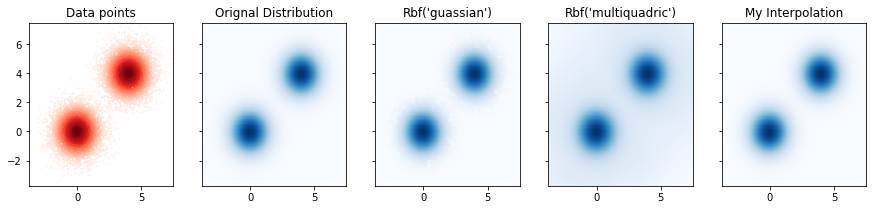

In [102]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex = True, sharey = True)

# sample points
axes[0].scatter(
    x = dat_pts[:, 0], 
    y = dat_pts[:, 1], 
    c = value.reshape(-1,), s = 1, 
    cmap = "Reds")
axes[0].set_title("Data points")

# bivariate normal
axes[1].scatter(x = x_c, y = y_c, c = z_c, s = 1, cmap = "Blues", alpha = 1.0)
axes[1].set_title("Orignal Distribution")

# interpolation by Rbf
axes[2].scatter(x = x_c, y = y_c, c = z_rbf_gauss, s = 1, cmap = "Blues", alpha = 1.0)
axes[2].set_title("Rbf('guassian')")

# interpolation by Rbf
axes[3].scatter(x = x_c, y = y_c, c = z_rbf_multiq, s = 1, cmap = "Blues", alpha = 1.0)
axes[3].set_title("Rbf('multiquadric')")

# my simple interpolation
axes[4].scatter(x = x_c, y = y_c, c = z_test, s = 1, cmap = "Blues", alpha = 1.0)
axes[4].set_title("My Interpolation")

axes[0].set_xlim(coor_range)
axes[0].set_ylim(coor_range)
plt.show()